# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# answer ='17 campaigns'

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_curve, RocCurveDisplay

%matplotlib inline


In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
print(df.shape)

(41188, 21)


In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



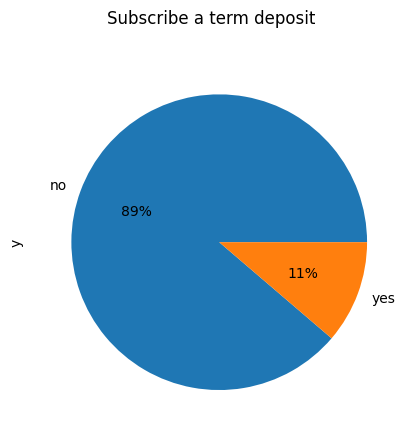

In [5]:
pie_labely = df['y'].value_counts().plot.pie(autopct="%1.0f%%")
pie_labely.figure.suptitle("Subscribe a term deposit")
pie_labely.figure.savefig("./images/pie_label_Subscribed_Term_Deposit.png")

Only 11% of customer response to "yes" to our campaigns

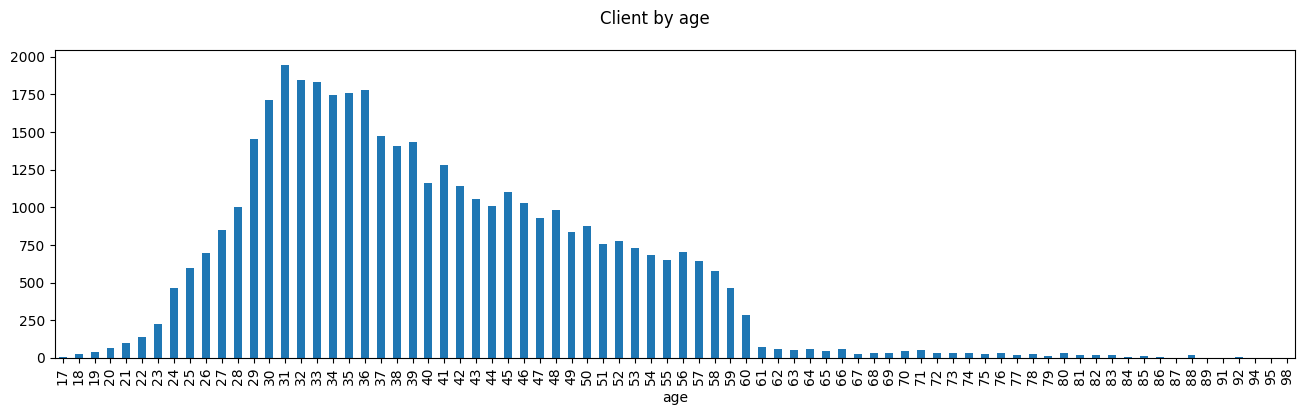

In [6]:
bar_age = df.groupby(["age"]).size().sort_index().plot.bar(figsize=(16, 4))
bar_age.figure.suptitle("Client by age")
bar_age.figure.savefig("./images/bar_client_by_age.png")

In [7]:
boxplt_strip_age = px.box(data_frame=df, x="age")
# boxplt_strip_age = sns.stripplot(data=df["age"], ax=boxplt_strip_age)
boxplt_strip_age.show()

In [8]:
# print("")
# print(df["age"].quantile([.25, .5, .75]))
# print("")
mean_age = df.groupby(["age"])["age"].size().mean()
print(f"Average size of each age group is {mean_age}")
print("")
age_range = df.groupby(["age"]).size()[df.groupby(["age"]).size().apply(lambda x: x>mean_age)].index
age_percent = df.query("age > 25 and age < 58")["age"].count()/df["age"].count() * 100
print(f"{round(age_percent, 2)}% of our customers are between {age_range.min()} and {age_range.max()}")


Average size of each age group is 528.0512820512821

90.54% of our customers are between 25 and 58


Average size of each age group is 528.

90.54% of our customers are between 25 and 58.

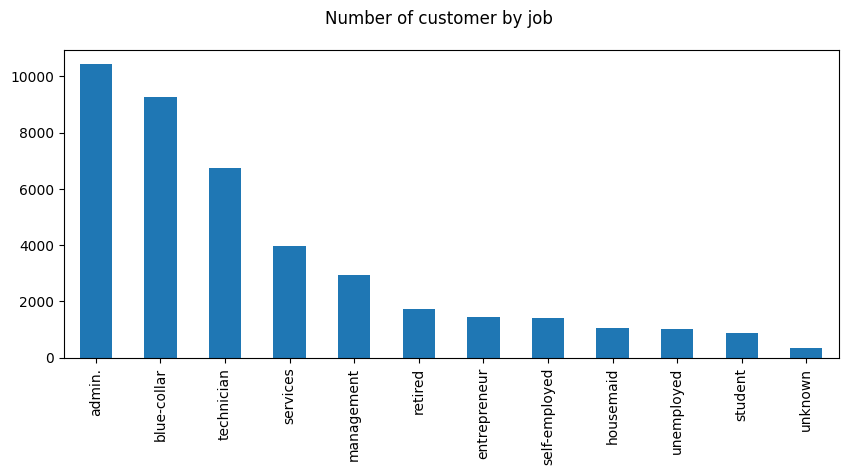

In [9]:
bar_job = df["job"].value_counts().sort_values(ascending=False).plot.bar(figsize=(10, 4))
bar_job.figure.suptitle("Number of customer by job")
bar_job.figure.savefig("./images/bar_num_job_by_customer.png")

C:\Users\hyssh\AppData\Local\Temp\ipykernel_3132\3837763556.py:9: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



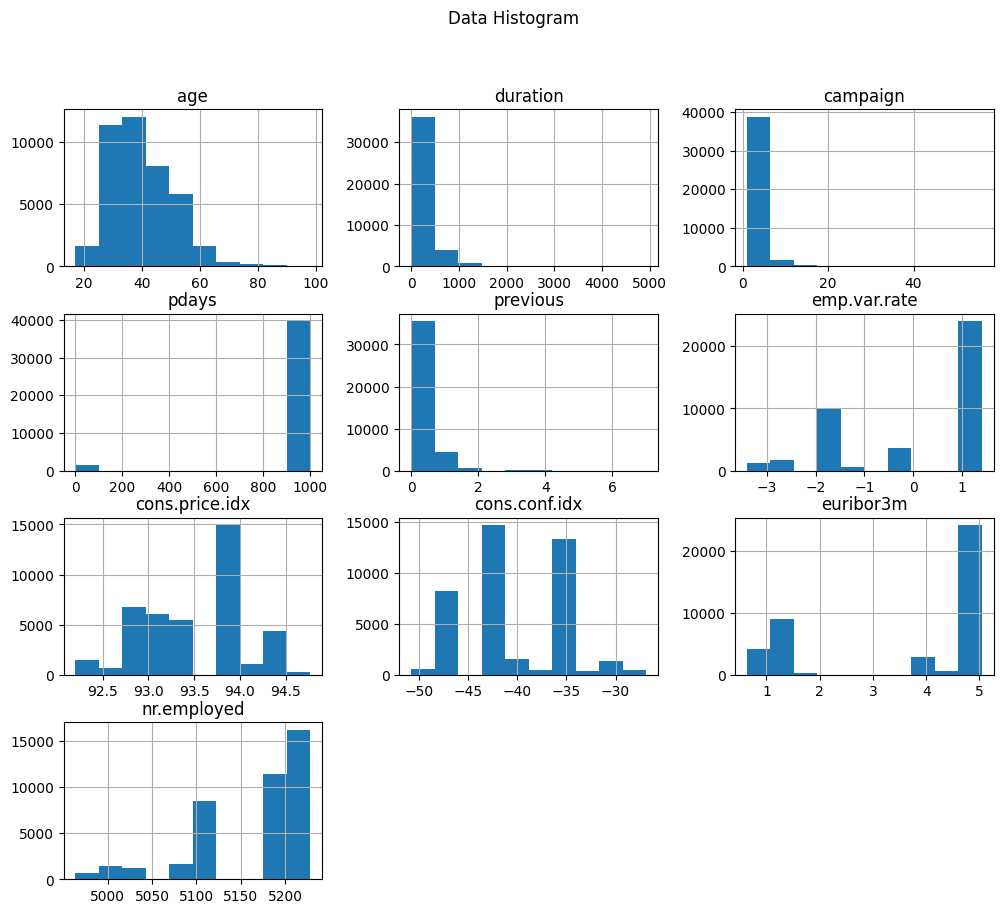

In [10]:
# objectColumnNames = df.select_dtypes(include=object)

# for col in objectColumnNames.columns:
#     bar = df[col].value_counts().sort_values().plot.bar(figsize=(16, 4))
#     bar.figure.suptitle(f"Client by {col}")
#     bar.figure.savefig(f"./images/bar_client_by_{col}.png")

fig_hist_overall, ax = plt.subplots(figsize=(12,10))
df.hist(ax=ax)
fig_hist_overall.suptitle("Data Histogram")
fig_hist_overall.savefig("./images/fig_hist_overall.png")

In [11]:
# fig_pairplot = sns.pairplot(df, hue ="y")
# fig_pairplot.figure.suptitle("Pairplot")
# fig_pairplot.savefig("./images/pairplot.png")

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

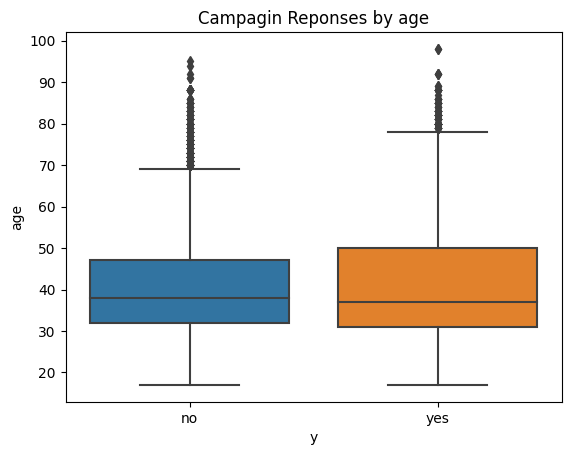

In [13]:
fig_boxplot_age_by_y = sns.boxplot(data= df, x="y", y="age")
fig_boxplot_age_by_y.set_title("Campagin Reponses by age")
fig_boxplot_age_by_y.figure.savefig("./images/fig_boxplot_response_by_age.png")

Age isn't important for the campagin.

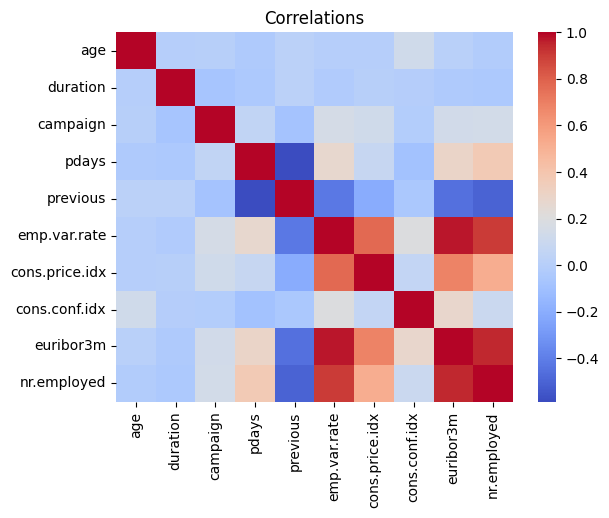

In [14]:
fig_heatmap = sns.heatmap(df.corr(), cmap="coolwarm")
fig_heatmap.set_title("Correlations")
fig_heatmap.figure.savefig("./images/fig_heatmap_numeric_data.png")

nr.employed and euribor3m has strong correlation.

- nr.employed: number of employees - quarterly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)

In [15]:
df["nr.emp.yrs"] = df["nr.employed"].apply(lambda x: int(x/365))
df["nr.emp.yrs"]

0        14
1        14
2        14
3        14
4        14
         ..
41183    13
41184    13
41185    13
41186    13
41187    13
Name: nr.emp.yrs, Length: 41188, dtype: int64

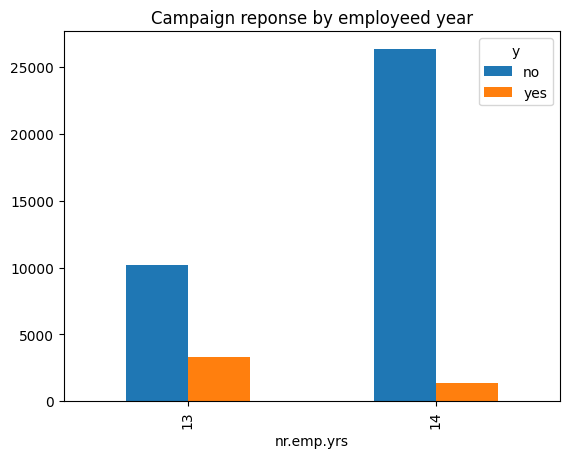

In [16]:
fig_bar_empyrs_y = df.groupby(["nr.emp.yrs", "y"]).size().unstack().plot.bar()
fig_bar_empyrs_y.set_title("Campaign reponse by employeed year")
fig_bar_empyrs_y.figure.savefig("./images/fig_bar_empyrs_y.png")

Employed year around 13 years is relatively response postive to our campaing

In [17]:
# sns.scatterplot(data=df, x="nr.employed", y="euribor3m", hue="y")
# sns.boxplot(data=df,x="nr.emp.yrs", y="euribor3m", hue="y")
# sns.barplot(data=df, x="nr.emp.yrs")

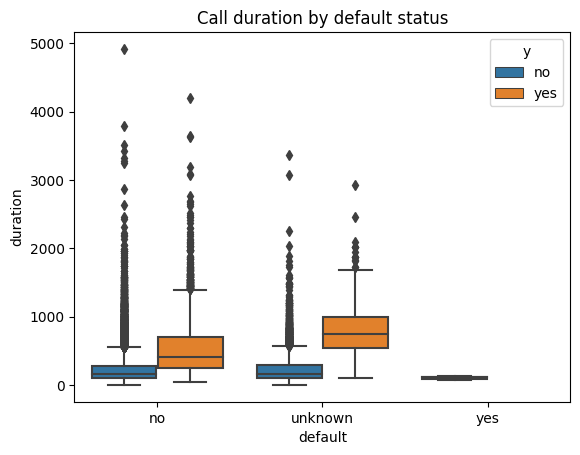

In [18]:
# df.groupby(["poutcome", "y"]).size().plot.bar()
fig_boxplt_default_duration_by_y = sns.boxplot(data=df, x="default", y="duration", hue="y")
fig_boxplt_default_duration_by_y.set_title("Call duration by default status")
fig_boxplt_default_duration_by_y.figure.savefig("./images/fig_boxplot_default_duration_by_y.png")

Customers who had default wasn't the targeted for the campaings

<AxesSubplot:title={'center':'Campaign and Duration analysis'}, xlabel='campaign', ylabel='duration'>

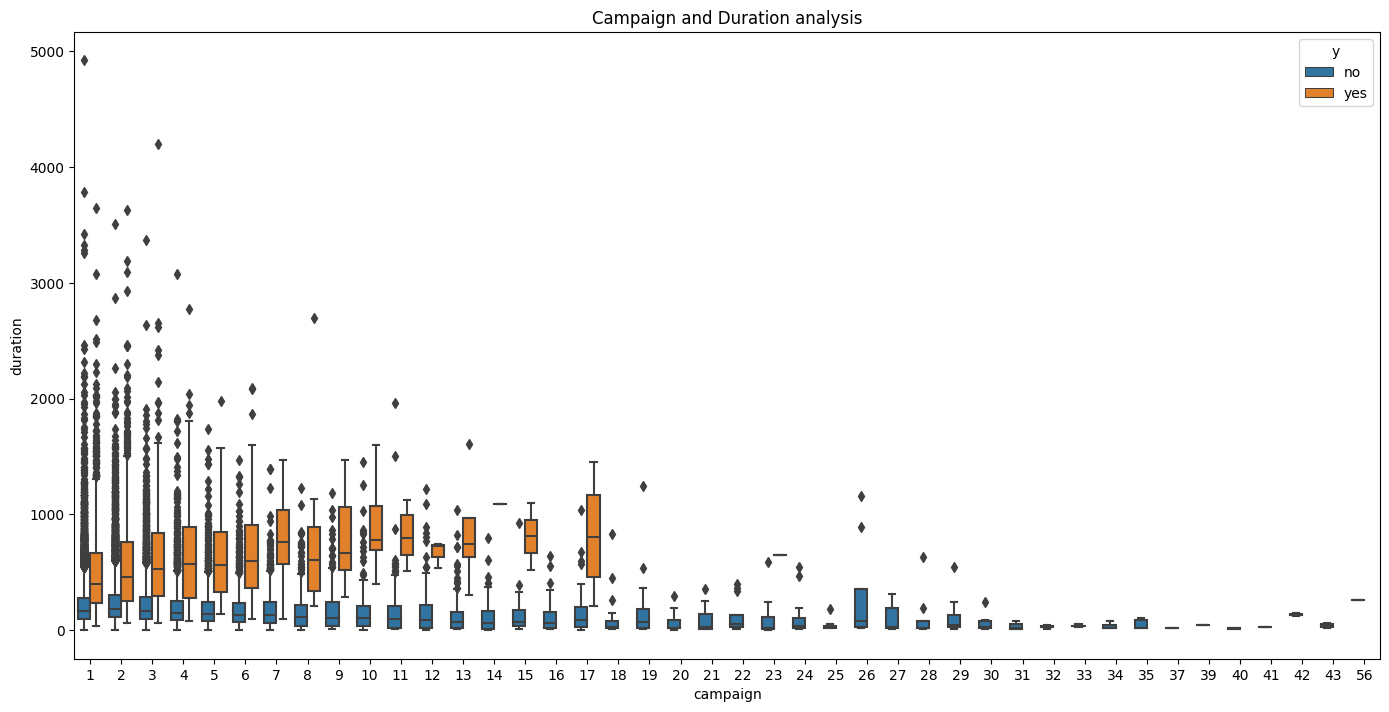

In [19]:
# fig_boxplot_campaing_label, ax = plt.subplots(figsize=(10,7))
sns.despine(left=True, bottom=True)
box_campaign_duration = sns.boxplot(data=df, x="campaign", y="duration", hue="y")
box_campaign_duration.figure.set_size_inches(14,7)
box_campaign_duration.figure.tight_layout()
box_campaign_duration.set_title("Campaign and Duration analysis")
box_campaign_duration.figure.savefig("./images/boxplot_campaing_Durtaion_y.png")
box_campaign_duration

Contacting the customer for the same campaing more than 18 times isn't effective

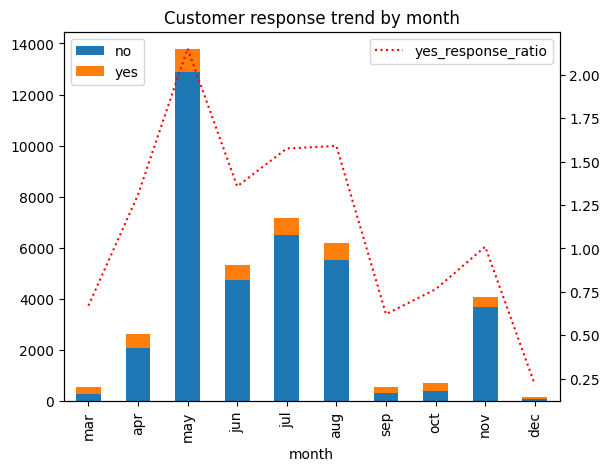

In [20]:
months = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
monthly_campaign_res = df.groupby(["month", "y"]).size().unstack().reindex(months)
monthly_campaign_res['yes_ratio'] = monthly_campaign_res.unstack()["yes"]/monthly_campaign_res.unstack().sum()*100
# monthly_campaign_res
# monthly_campaign_res[["no", "yes"]].plot.bar()
# monthly_campaign_res["yes_ratio"].plot.line()

ax = monthly_campaign_res[["no", "yes"]].plot.bar(stacked=True)
ax.legend(loc="upper left")
ax2 = ax.twinx()
ax2.plot(monthly_campaign_res["yes_ratio"], color="red", linestyle="dotted")
ax2.set_title("Customer response trend by month")
ax2.legend(loc="upper right", labels=["yes_response_ratio"])
ax2.figure.savefig("./images/stackedbar_line_monthly_reponse.png")
plt.show()


Each month show difference postive reponse ratio

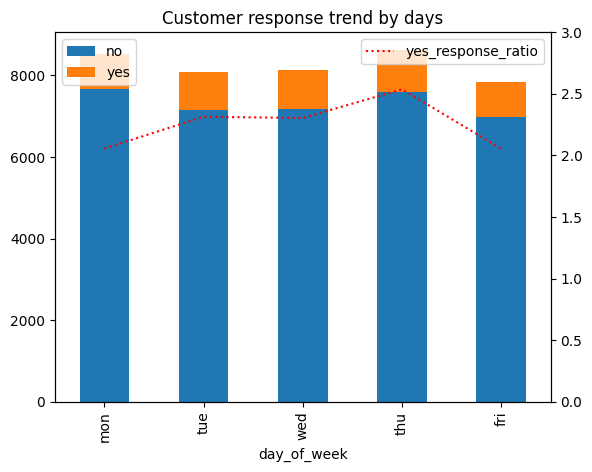

In [21]:
days = ["mon", "tue", "wed", "thu", "fri"]
daily_campaign_res = df.groupby(["day_of_week", "y"]).size().unstack().reindex(days)
daily_campaign_res['yes_ratio'] = daily_campaign_res.unstack()["yes"]/daily_campaign_res.unstack().sum()*100
# monthly_campaign_res
# monthly_campaign_res[["no", "yes"]].plot.bar()
# monthly_campaign_res["yes_ratio"].plot.line()

ax = daily_campaign_res[["no", "yes"]].plot.bar(stacked=True)
ax.legend(loc="upper left")
ax2 = ax.twinx()
ax2.plot(daily_campaign_res["yes_ratio"], color="red", linestyle="dotted")
ax2.set_title("Customer response trend by days")
ax2.set_ylim(0, 3)
ax2.legend(loc="upper right", labels=["yes_response_ratio"])
ax2.figure.savefig("./images/stackedbar_line_daily_reponse.png")
plt.show()


There is no big difference between day

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [22]:
if "nr.emp.yrs" in df.columns:
    print("nr.emp.yrs found in the dataframe")
else:
    df["nr.emp.yrs"] = df["nr.employed"].apply(lambda x: int(x/365))


nr.emp.yrs found in the dataframe


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [24]:
encodingTargetColumnNames = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome']
ohe = OneHotEncoder(drop="if_binary", handle_unknown="infrequent_if_exist").fit(df[encodingTargetColumnNames])
ohe.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
        'professional.course', 'university.degree', 'unknown'],
       dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['cellular', 'telephone'], dtype=object),
 array(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
        'sep'], dtype=object),
 array(['fri', 'mon', 'thu', 'tue', 'wed'], dtype=object),
 array(['failure', 'nonexistent', 'success'], dtype=object)]

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [25]:
label = "y"
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1).astype("int64")
X, y = df.drop(label, axis=1), df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,nr.emp.yrs
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,14
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,14
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,14
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,14
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,14


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

```
Logistic Regression (Baseline)
K Nearest Neighbor
Decision Trees
Support Vector Machines
```

In [27]:
encodingTargetColumnNames = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome']
numericTargetColumnNames = ['age', 'duration', 'campaign', 'pdays', 'previous','emp.var.rate','cons.price.idx','cons.conf.idx', 'euribor3m','nr.employed','nr.emp.yrs']

transformer = make_column_transformer(
    (OneHotEncoder(drop="if_binary", handle_unknown="infrequent_if_exist"), encodingTargetColumnNames),
    (StandardScaler(), numericTargetColumnNames)
)

lr = Pipeline([
    ('transform', transformer),
    ('lr', LogisticRegression(max_iter=10000))
]).fit(X_train, y_train)

lr.score(X_test, y_test)

0.9134094035769199

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [28]:
lr2 = Pipeline([
    ('transform', transformer),
    ('lr', LogisticRegression(max_iter=10000, C=0.1))
]).fit(X_train, y_train)


### Problem 9: Score the Model

What is the accuracy of your model?

In [29]:
lr2.score(X_test, y_test)

0.9126810714574735

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [30]:
trained_models = []
train_scores = []
test_scores = []
precisions = []
recalls = []
rocs = []
displays = []
durations = []

def train_model(name, estimator, X_train, y_train, X_test, y_test):
    model = Pipeline([
        ("transformer", transformer),
        ("estimator", estimator)
    ])
    start_time = time.time_ns()
    model.fit(X_train, y_train)
    duration = (time.time_ns() - start_time)/1000000000

    y_pred = model.predict(X_test)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_curve(y_test, y_pred)

    dis = RocCurveDisplay.from_predictions(y_test, y_pred)
    dis.figure_.suptitle(f"{name} ROC Curve")
    dis.figure_.savefig(f"./images/{name}_roc_curve.png")
    
    return model, score_train, score_test, precision, recall, roc, dis, duration

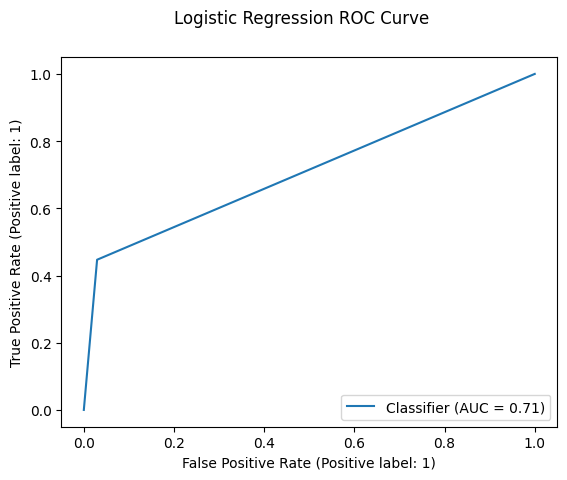

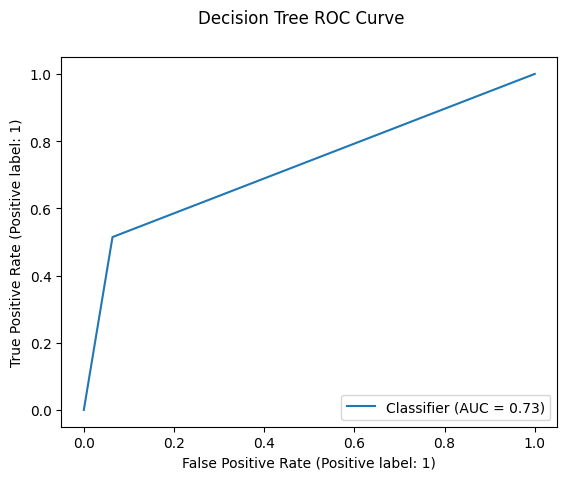

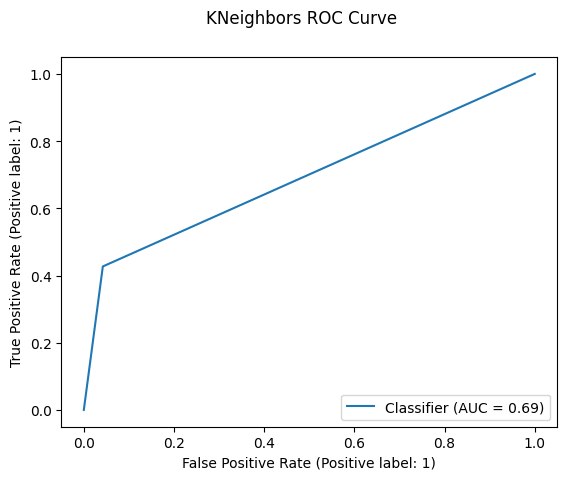

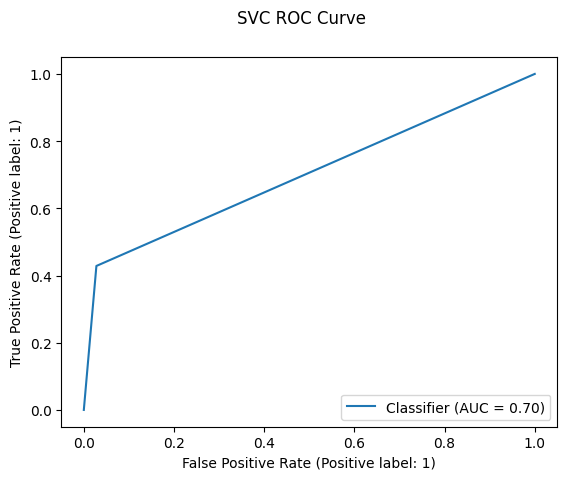

In [31]:
estimators = [LogisticRegression(max_iter=10000), DecisionTreeClassifier(), KNeighborsClassifier(), SVC()]
estimator_names = ["Logistic Regression", "Decision Tree", "KNeighbors", "SVC"]

for i, estimator in enumerate(estimators):
    model, score_train, score_test, precision, recall, roc, dis, duration = train_model(estimator_names[i], estimator, X_train, y_train, X_test, y_test)
    trained_models.append(model)
    train_scores.append(score_train)
    test_scores.append(score_test)
    precisions.append(precision)
    recalls.append(recall)
    rocs.append(roc)
    displays.append(dis)
    durations.append(duration)


In [32]:
results = {"estimator_name": estimator_names, "duration":durations ,"score_train": train_scores, "score_test": test_scores, "precision":precisions, "recall":recalls}
results_df = pd.DataFrame(results).set_index("estimator_name")
results_df

,duration,score_train,score_test,precision,recall
estimator_name,,,,,
Logistic Regression,1.188624,0.910825,0.913409,0.650485,0.446998
Decision Tree,0.302958,1.000000,0.890346,0.497848,0.514455
KNeighbors,0.083599,0.928341,0.899895,0.553846,0.426983
SVC,17.504051,0.921820,0.912762,0.653107,0.428466


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [33]:
def train_model_optimization(name, estimator, X_train, y_train, X_test, y_test, params):
    model = Pipeline([
        ("transformer", transformer),
        ("estimator", estimator)
    ])

    gscv = GridSearchCV(
        estimator=model, 
        param_grid=params,
        cv=5
    )

    start_time = time.time_ns()
    gscv.fit(X_train, y_train)
    duration = (time.time_ns() - start_time)/1000000000

    y_pred = gscv.best_estimator_.predict(X_test)
    score_train = gscv.score(X_train, y_train)
    score_test = gscv.score(X_test, y_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_curve(y_test, y_pred)

    dis = RocCurveDisplay.from_predictions(y_test, y_pred)
    dis.figure_.suptitle(f"{name} ROC Curve")
    dis.figure_.savefig(f"./images/{name}_roc_curve.png")
    
    return gscv, score_train, score_test, precision, recall, roc, dis, duration

c:\Users\hyssh\Anaconda3\envs\pcmlai\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hyssh\Anaconda3\envs\pcmlai\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hyssh\Anaconda3\envs\pcmlai\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\hyssh\Anaconda3\envs\pcmlai\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    s

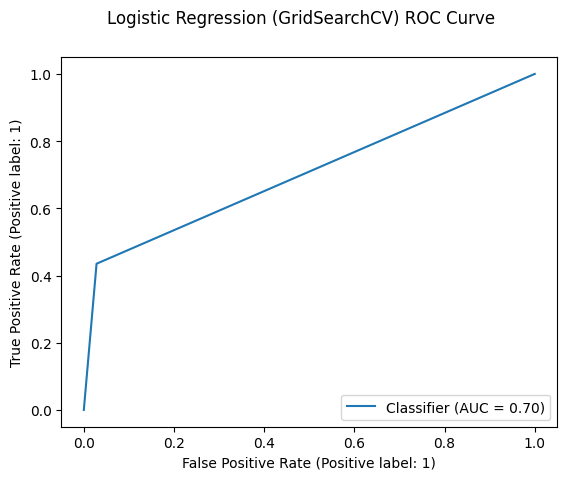

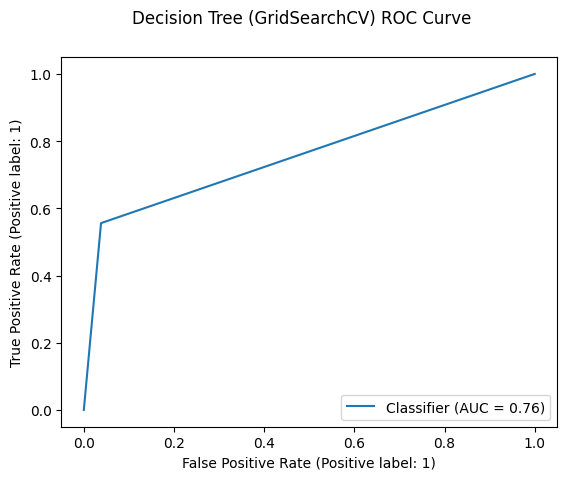

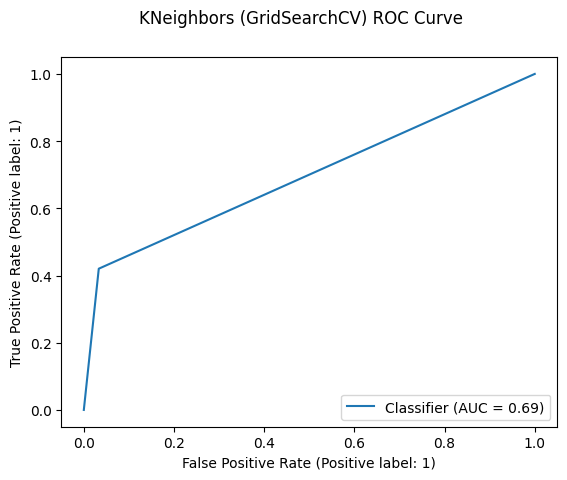

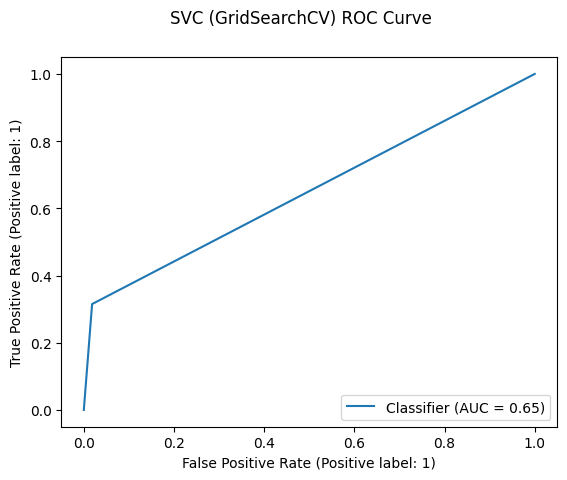

In [34]:
estimators2 = [LogisticRegression(max_iter=10000), DecisionTreeClassifier(), KNeighborsClassifier(), SVC()]
estimator_names2 = ["Logistic Regression (GridSearchCV)", "Decision Tree (GridSearchCV)", "KNeighbors (GridSearchCV)", "SVC (GridSearchCV)"]

lg_params = {"estimator__penalty": ['l1'], "estimator__C":[0.1, 0.01], "estimator__solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
dtc_params = {'estimator__criterion':['gini','entropy'],'estimator__max_depth':[6,7]}
KNN_params = {'estimator__n_neighbors': [3, 5, 7, 9, 11] }
SVC_params = {'estimator__C': [0.1], 
              'estimator__gamma': [0.1, 0.01],
              'estimator__kernel': ['rbf']} 

all_params = [lg_params, dtc_params, KNN_params, SVC_params ]


for i, estimator in enumerate(estimators2):
    model, score_train, score_test, precision, recall, roc, dis, duration = train_model_optimization(estimator_names2[i], estimator, X_train, y_train, X_test, y_test, all_params[i])
    trained_models.append(model)
    train_scores.append(score_train)
    test_scores.append(score_test)
    precisions.append(precision)
    recalls.append(recall)
    rocs.append(roc)
    displays.append(dis)
    durations.append(duration)

In [35]:
all_names = estimator_names + estimator_names2
results2 = {"estimator_name": all_names, "duration":durations ,"score_train": train_scores, "score_test": test_scores, "precision":precisions, "recall":recalls}
results_df2 = pd.DataFrame(results2).set_index("estimator_name")
results_df2

,duration,score_train,score_test,precision,recall
estimator_name,,,,,
Logistic Regression,1.188624,0.910825,0.913409,0.650485,0.446998
Decision Tree,0.302958,1.000000,0.890346,0.497848,0.514455
KNeighbors,0.083599,0.928341,0.899895,0.553846,0.426983
SVC,17.504051,0.921820,0.912762,0.653107,0.428466
Logistic Regression (GridSearchCV),18.778390,0.911276,0.913167,0.653675,0.435137
Decision Tree (GridSearchCV),3.254401,0.921716,0.917537,0.641026,0.555967
KNeighbors (GridSearchCV),10.634504,0.920363,0.907178,0.608369,0.420311
SVC (GridSearchCV),134.315391,0.906559,0.908878,0.677831,0.315048


In [53]:
best_model = trained_models[5]
best_model.best_params_

{'estimator__criterion': 'gini', 'estimator__max_depth': 6}

`Decision Tree (GridSearchCV)` {'estimator__criterion': 'gini', 'estimator__max_depth': 6}

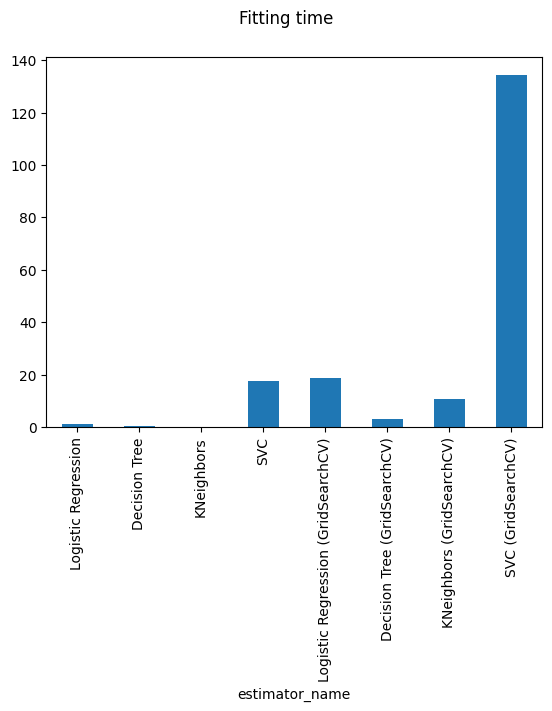

In [49]:
fig_result = results_df2["duration"].plot.bar()
fig_result.figure.suptitle("Fitting time")
fig_result.figure.savefig("./images/bar_fitting_time.png")

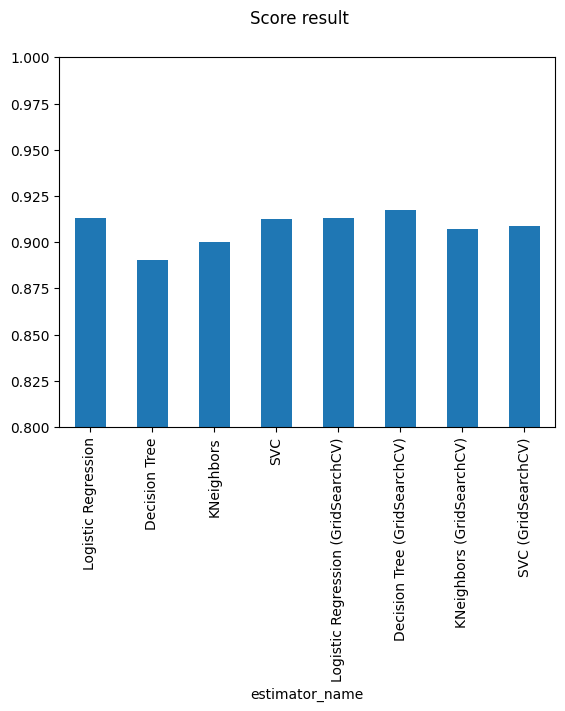

In [42]:
result_bar = results_df2["score_test"].plot.bar()
result_bar.set_ylim(0.8, 1)
result_bar.figure.suptitle("Score result")
result_bar.figure.savefig("./images/bar_estimator_score.png")

##### Questions

How to integrate the best model with CRM?
